# Graph Convolution Network (GCN) for a classification problem

We will work with the CORA dataset from pytorch geometirc.
Each paper is assingned a high dimensional vector based on its contents
and we will work with the directed graph formed by the citations.
Each paper or node is classified based on research topic.

In [1]:
from torch_geometric.datasets import Planetoid

# Load the CORA dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# Access the first graph object
data = dataset[0]

In [2]:
print("No. of nodes = ", data['x'].shape[0])
print("No. of edges = ", data['edge_index'].shape[1])
print("Classification labels range from ", data['y'].min(), " to ", data['y'].max())

No. of nodes =  2708
No. of edges =  10556
Classification labels range from  tensor(0)  to  tensor(6)


To work with the jax ecosystem we will change the data type to a jax array

In [3]:
import jax.numpy as jnp

x = jnp.asarray(data['x'].numpy())
edge_index = jnp.asarray(data['edge_index'].numpy())
y = jnp.asarray(data['y'].numpy())

num_nodes = x.shape[0]
node_vector_size = x.shape[1]
num_classes = int(y.max()) + 1

We will use the edge index information to form the adjacency matrix which will be 2D jax array. Ideally we should use sparse matrices for efficiency.

In [4]:
A = jnp.zeros((num_nodes,num_nodes))
A = A.at[edge_index[0], edge_index[1]].set(1)


degree = A.sum(axis=0) # Check axis

print("Adjacency matrix of dimensions ", A.shape)
print("Min degree ", degree.min())
print("Max degree ", degree.max())

Adjacency matrix of dimensions  (2708, 2708)
Min degree  1.0
Max degree  168.0


Now we will use the gcn class defined in gcn.py to transform the node features to vectors of size = number of classes. Initially the parameters of the transformation are set randomly.

In [5]:
import jax
from gcn import GCN

key = jax.random.PRNGKey(42)

model_key, key = jax.random.split(key)
gcn_transformation = GCN([node_vector_size, 100, 100, num_classes], model_key)

We will randomly select nodes for training. We will use one-hot encodings as target vectors.

In [6]:
num_of_nodes_in_training_set = int(0.5 * num_nodes)
training_set = jax.random.choice(key, num_nodes, (num_of_nodes_in_training_set,), replace=False)

Y = jnp.zeros((num_nodes, num_classes), dtype=int)
Y = Y.at[training_set,y[training_set]].set(1)

Now we can define our cross entropy loss function for the training set. To define the model, we apply the softmax function to the node embeddings we get as output. This is useful as we will generate one-hot encodings as our target output and use the cross-entropy function.

In [7]:
def loss_fn(gcn_transformation, x, A, degree, Y):
    z = gcn_transformation(x, A, degree)
    predicted_probs =  jax.nn.softmax(z, axis = 1)
    cross_entropy_terms = - Y * jnp.log(predicted_probs)
    return cross_entropy_terms.sum()

We define functions for calculating the training and overall accuracy

In [8]:
def training_accuracy(z, y):
    predicted_probs =  jax.nn.softmax(z, axis = 1)[training_set]
    predicted_labels = predicted_probs.argmax(axis = 1)
    predicted_correct = jnp.where(y[training_set] == predicted_labels, 1, 0)
    return predicted_correct.sum() / predicted_correct.shape[0]

def overall_accuracy(z, y):
    predicted_probs =  jax.nn.softmax(z, axis = 1)
    predicted_labels = predicted_probs.argmax(axis = 1)
    predicted_correct = jnp.where(y == predicted_labels, 1, 0)
    return predicted_correct.sum() / predicted_correct.shape[0]
    

Now we begin the training process

In [9]:
import equinox as eqx
import optax

optim = optax.adam(learning_rate=5e-2)
opt_state = optim.init(gcn_transformation)

loss_values = []
train_acc_list = []
overall_acc_list = []

for iter_id in range(500):
    value, grads = eqx.filter_value_and_grad(loss_fn)(gcn_transformation, x, A, degree, Y)

    z = gcn_transformation(x, A, degree)
    train_acc = training_accuracy(z, y)
    overall_acc = overall_accuracy(z, y)
    
    updates, opt_state = optim.update(grads, opt_state)
    gcn_transformation = eqx.apply_updates(gcn_transformation, updates)

    print(f"{iter_id:03d} Loss = {value:.2e}, Train acc = {train_acc:.2e}, Overall acc = {overall_acc:.2e}")

    loss_values.append(value)
    train_acc_list.append(train_acc)
    overall_acc_list.append(overall_acc)

000 Loss = 3.18e+03, Train acc = 1.13e-01, Overall acc = 1.14e-01
001 Loss = 2.62e+03, Train acc = 2.85e-01, Overall acc = 2.59e-01
002 Loss = 2.24e+03, Train acc = 3.69e-01, Overall acc = 3.44e-01
003 Loss = 2.03e+03, Train acc = 4.41e-01, Overall acc = 4.12e-01
004 Loss = 1.84e+03, Train acc = 4.97e-01, Overall acc = 4.66e-01
005 Loss = 1.70e+03, Train acc = 5.42e-01, Overall acc = 5.06e-01
006 Loss = 1.57e+03, Train acc = 5.76e-01, Overall acc = 5.34e-01
007 Loss = 1.48e+03, Train acc = 6.09e-01, Overall acc = 5.64e-01
008 Loss = 1.41e+03, Train acc = 6.31e-01, Overall acc = 5.86e-01
009 Loss = 1.35e+03, Train acc = 6.62e-01, Overall acc = 6.08e-01
010 Loss = 1.31e+03, Train acc = 6.88e-01, Overall acc = 6.36e-01
011 Loss = 1.27e+03, Train acc = 7.07e-01, Overall acc = 6.51e-01
012 Loss = 1.24e+03, Train acc = 7.22e-01, Overall acc = 6.67e-01
013 Loss = 1.21e+03, Train acc = 7.36e-01, Overall acc = 6.81e-01
014 Loss = 1.18e+03, Train acc = 7.48e-01, Overall acc = 6.93e-01
015 Loss =

Now let us plot the loss plot

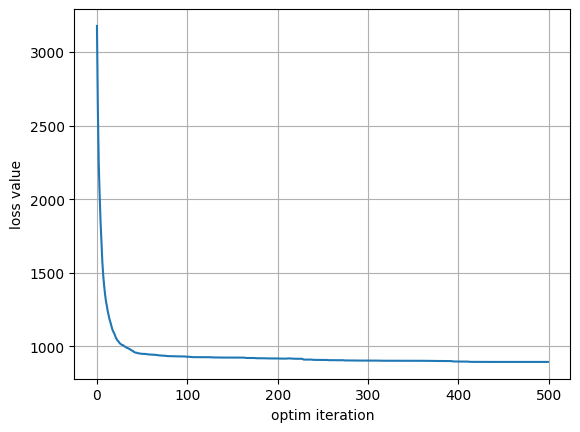

In [10]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel("optim iteration")
plt.ylabel("loss value")
plt.grid()
plt.show()

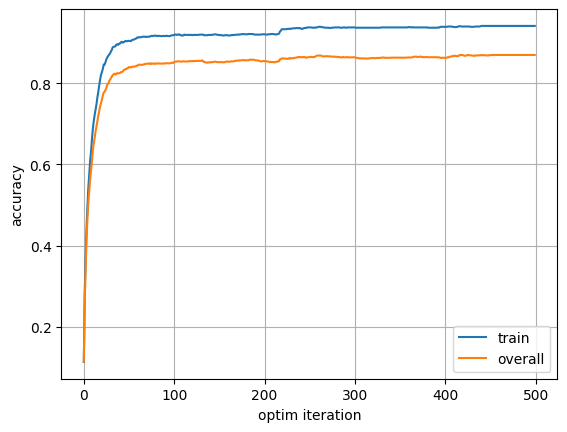

In [11]:
plt.plot(train_acc_list, label="train")
plt.plot(overall_acc_list, label="overall")
plt.legend()
plt.xlabel("optim iteration")
plt.ylabel("accuracy")
plt.grid()
plt.show()

In [14]:
print(f"Final overall accuracy = {100*overall_acc_list[-1]:.2f}%")

Final overall accuracy = 87.00%
